# 23_04_25_07_erythroid_lineage_下游分析3_转录爆发基因的单个速率基因查看

In [1]:
import sys
sys.path = ["../.."] + sys.path # 切换到项目目录下

import scanpy as sc
import scvelo as scv
import velovgi

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


Global seed set to 0
/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## 1. 读取结果

In [2]:
# adata_dir = "tmp/erythroid_lineage/adata"
# adata_dir = "tmp/erythroid_lineage2/adata"
adata_dir = "tmp/erythroid_lineage_cluster/adata"
adata = velovgi.tl.read_adata(adata_dir)
batch_key = "stage"
cluster_key = "celltype"
adata

load tmp/erythroid_lineage_cluster/adata/adata.h5ad
load tmp/erythroid_lineage_cluster/adata/sample_recover.pkl


AnnData object with n_obs × n_vars = 9815 × 2000
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'celltype_colors', 'neighbors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'sample_recover'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    layers: 'Ms', 'Mu', 'fit_t', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'

2. subsample_adata

In [3]:
# subsample_adata_dir = "./tmp/erythroid_lineage2/subsample_adata.h5ad"
subsample_adata_dir = "./tmp/erythroid_lineage_cluster/subsample_adata.h5ad"
subsample_adata = scv.read(subsample_adata_dir)
subsample_adata

AnnData object with n_obs × n_vars = 4907 × 2000
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    layers: 'Ms', 'Mu', 'fit_t', 'latent_time_velovi', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'

3. model

In [4]:
# velovgi_model = velovgi.tl.VELOVGI.load("tmp/erythroid_lineage/model", adata=adata, use_gpu=True)
# velovgi_model = velovgi.tl.VELOVGI.load("tmp/erythroid_lineage2/model", adata=adata, use_gpu=True)
velovgi_model = velovgi.tl.VELOVGI.load("tmp/erythroid_lineage_cluster/model", adata=adata, use_gpu=True)

INFO     File tmp/erythroid_lineage_cluster/model/model.pt already downloaded                                      


## 2. 单个基因的速率图(这里moment出问题,导致算出的adata.layer中的spliced和unspliced不能直接用)

In [5]:
gene_list = ["Hba-x", "Hbb-y", "Smim1"]
for gene in gene_list:
    if gene not in list(adata.var.index):
        print(gene)
# 此处MRURK基因Smlm1暂时不存在，应该是过滤高变基因的时候过滤掉了，无伤大雅，整体数据集不抽样的话应该就过滤不掉了。

# gene_list = ["Hba-x", "Hbb-y"]

In [7]:
# adata.layers["velocity_u"] = adata.layers["velocity_u"].A

1. 一维速率(原本只有velocity,没有velocity_u)

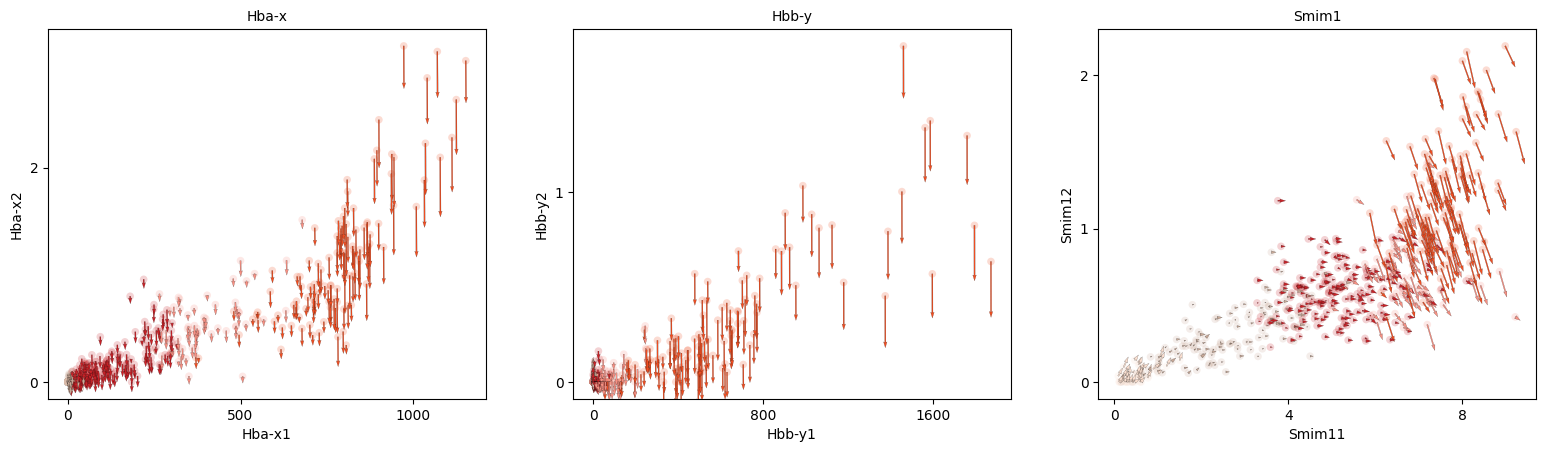

In [8]:
# 先抽取部分细胞展示
adata2 = adata.copy()
sc.pp.subsample(adata2, n_obs=500)

# kwargs = dict(frameon=False, fontsize=20)

# TODO: 需要展现一下二维速率图
scv.pl.velocity_embedding(adata2, basis=gene_list, color=cluster_key)

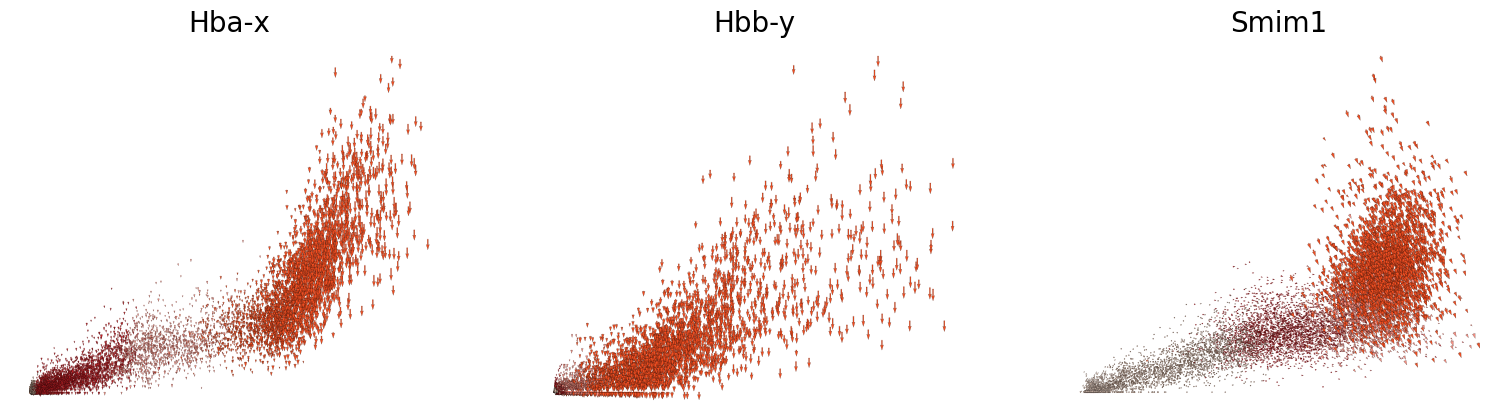

In [9]:
kwargs = dict(arrow_length=100, frameon=False, fontsize=20)

# TODO: 需要展现一下二维速率图
scv.pl.velocity_embedding(adata, basis=gene_list, color=cluster_key, **kwargs)
# scv.pl.velocity_embedding(subsample_adata, basis=gene_list, color=cluster_key, **kwargs)

2. 二维速率，需要提取unspliced的速率，要从模型中重新拿

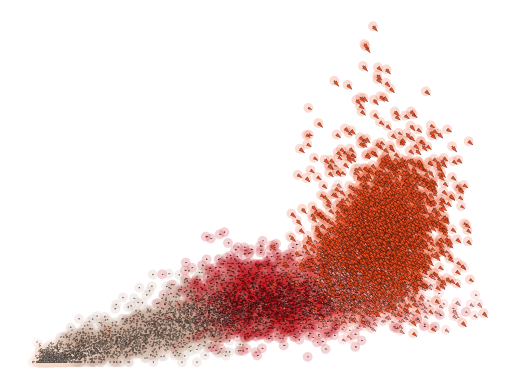

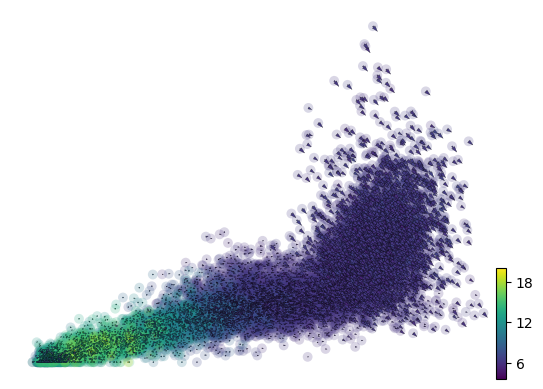

In [10]:
# murk_gene = "Hba-x"
# murk_gene = "Hbb-y"
murk_gene = "Smim1"
time_key = "latent_time"

adata.obs[time_key] = adata[:, murk_gene].layers["fit_t"].A[:, 0] # 提取该基因的时间

v_kwargs={'vkey': 'velocity', 'size': 200, 'frameon': False, 'title': '',
          'legend_loc': 'none', 'linewidth': .15, "angles": "uv", "arrow_length":100} # 这里绘制箭头的angles参数是发现bug的地方

scv.pl.velocity_embedding(adata, basis=murk_gene, color=cluster_key, **v_kwargs)
scv.pl.velocity_embedding(adata, basis=murk_gene, color=time_key, colorbar=True, **v_kwargs)

3. 为了确保结果准确，选择少一点的细胞个数或者手动指定速率,在这里调试发现,是scv.pl.velocity_embedding绘制箭头参数的angles参数有问题(https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.quiver.html#matplotlib.axes.Axes.quiver)

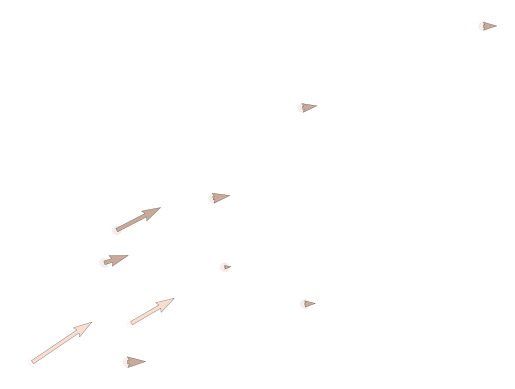

In [11]:
import numpy as np

topn=10
# topn=100
tmp_adata = adata[:topn, murk_gene]

# print(type(tmp_adata.layers["spliced"]), type(tmp_adata.layers["unspliced"]))
# print(tmp_adata[:, murk_gene].layers["velocity"], tmp_adata[:, murk_gene].layers["velocity_u"])

# # 手动指定s,u的速率
# tmp_adata.layers["velocity"] = np.array([1,1,1,1,1,1,1,1,1,1]).reshape(10,1)
# tmp_adata.layers["velocity_u"] = np.array([1,1,1,-1,1,1,1,-2,1,-3]).reshape(10,1)

# # TODO: 出Bug的地方,没有u是在s上的一维速率,有了u是在u上的一维速率(按道理应该是二位速率了)
# del tmp_adata.layers["velocity_u"]

scv.pl.velocity_embedding(tmp_adata, basis=murk_gene, color=cluster_key, **v_kwargs)

## 3. 这里的速率箭头太多了，像CellDancer一样，对于部分细胞展示速率箭头

CellDancer里自己绘图了，不用跟他一样那么麻烦，想着如何使用sc

1. 先构造与原本adata细胞数量相同，但是基因个数指定的tmp_adata

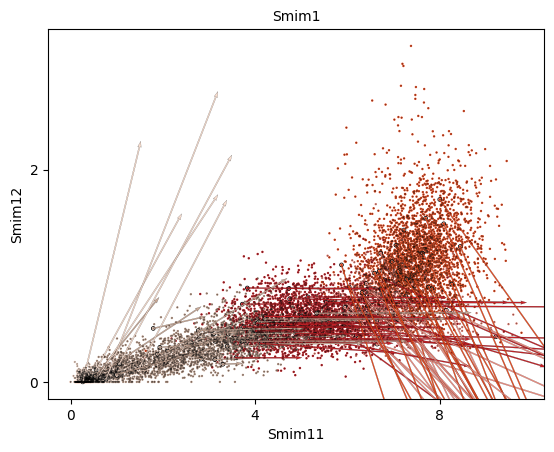

AnnData object with n_obs × n_vars = 9815 × 1
    obs: 'celltype'
    uns: 'celltype_colors'
    obsm: 'X_umap', 'velocity_umap'
    layers: 'spliced', 'unspliced', 'Mu', 'Ms', 'velocity', 'velocity_u'

In [12]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

import anndata as ad

np.random.seed(0)
cell_num = adata.shape[0]
n = 100
index_list = np.random.choice(np.arange(cell_num), size=n, replace=False)

murk_gene_list = [murk_gene] 
tmp_adata_shape = (adata.shape[0], len(murk_gene_list))
X=csr_matrix(tmp_adata_shape)
tmp_adata = ad.AnnData(X)
tmp_adata.obs[cluster_key] = "tmp" # 未选中的细胞使用临时占位符
tmp_adata.obs.iloc[index_list, 0] = list(adata[index_list].obs[cluster_key]) # 选中的细胞添加细胞类型
tmp_adata.var.index = murk_gene_list

tmp_adata.obsm["X_umap"] = adata.obsm["X_umap"]
tmp_adata.obsm["velocity_umap"] = adata.obsm["velocity_umap"]

tmp_adata.layers["spliced"] = adata[:, murk_gene_list].layers["spliced"] 
tmp_adata.layers["unspliced"] = adata[:, murk_gene_list].layers["unspliced"] 
tmp_adata.layers["Mu"] = adata[:, murk_gene_list].layers["Mu"].copy()
tmp_adata.layers["Ms"] = adata[:, murk_gene_list].layers["Ms"].copy()

velocity = X.copy().A
velocity[index_list] = adata[:, murk_gene_list].layers["velocity"][index_list]
velocity_u = X.copy().A
velocity_u[index_list] = adata[:, murk_gene_list].layers["velocity_u"][index_list]
tmp_adata.layers["velocity"] = velocity
tmp_adata.layers["velocity_u"] = velocity_u

adata_cluster_list = list(adata.obs[cluster_key].cat.categories)
adata_color_list = list(adata.uns["%s_colors"%cluster_key])
color_dict = dict(zip(adata_cluster_list, adata_color_list)) # 对抽样到的细胞保存原本颜色
color_dict["tmp"] = "#4d4d4d00" # 未抽样的设置为透明色
tmp_adata.uns["%s_colors"%cluster_key] = color_dict

figure, ax = plt.subplots()
scv.pl.scatter(adata, color=cluster_key, basis=murk_gene, ax=ax, show=False) # 先绘制一层底色，所有细胞按照细胞类型给颜色
scv.pl.scatter(tmp_adata, color=cluster_key, basis=murk_gene, add_outline=adata_cluster_list, ax=ax, show=False) # 对抽样到的细胞添加边界
scv.pl.velocity_embedding(tmp_adata, basis=murk_gene, color=cluster_key, ax=ax, arrow_size=0, arrow_length=0.5) # 这样绘制出来未抽样的细胞有
tmp_adata

2. 直接提取绘制，坐标轴会自动匹配（这种方法好）

View of AnnData object with n_obs × n_vars = 100 × 1
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition', 'latent_time'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'celltype_colors', 'neighbors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'sample_recover', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    layers: 'Ms', 'Mu', 'fit_t', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'

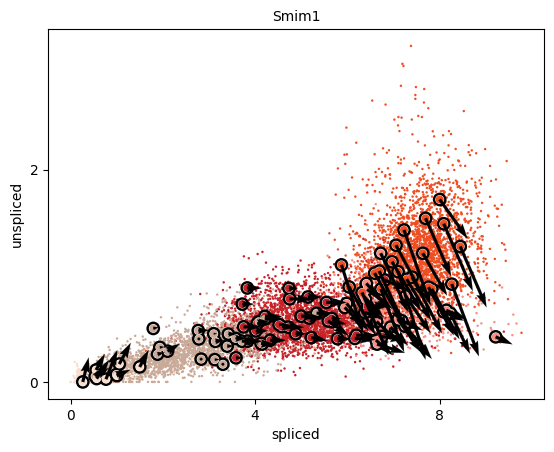

In [15]:
import math

tmp_adata = adata[index_list, murk_gene_list]

figure, ax = plt.subplots()
size = scv.pl.utils.default_size(adata)*math.log(adata.shape[0])

scv.pl.velocity_embedding(tmp_adata, color="black", basis=murk_gene, size=size, alpha=1 ,ax=ax, show=False) # 绘制抽样到的细胞黑色速率箭头
scv.pl.scatter(adata, color=cluster_key, basis=murk_gene, ax=ax, show=False) # 先绘制一层底色，所有细胞按照细胞类型给颜色
adata_cluster_list = list(adata.obs[cluster_key].cat.categories)
scv.pl.scatter(tmp_adata, color=cluster_key, basis=murk_gene, size=size, add_outline=adata_cluster_list, ax=ax, show=False) # 对抽样到的细胞添加边界
tmp_adata

## 甚至可以学习LatentVelo的单个基因的流行图

In [17]:
# TODO: